In [1]:
import os
import gc
import sys
import json
import glob
import random
from pathlib import Path

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import itertools
from tqdm import tqdm

import imgaug as ia
from imgaug import augmenters as iaa
from sklearn.model_selection import StratifiedKFold, KFold

In [2]:
DATA_DIR = Path('/src/fashion')
IMAGE_DIR = Path('/mnt/nas/iMaterial')
ROOT_DIR = Path('/src')

# For demonstration purpose, the classification ignores attributes (only categories),
# and the image size is set to 512, which is the same as the size of submission masks
NUM_CATS = 46
IMAGE_SIZE = 512

In [3]:
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

Using TensorFlow backend.


In [5]:
%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "weights/mask_rcnn_coco.h5")
# COCO_MODEL_PATH = os.path.join(ROOT_DIR, "fashion20190726T0816/mask_rcnn_fashion_0100.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [6]:
print(COCO_MODEL_PATH)

/src/weights/mask_rcnn_coco.h5


In [7]:
class FashionConfig(Config):
    NAME = "fashion"
    NUM_CLASSES = NUM_CATS + 1 # +1 for the background class
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2 # a memory error occurs when IMAGES_PER_GPU is too high
    
#     BACKBONE = 'resnet50'
    
    IMAGE_MIN_DIM = IMAGE_SIZE
    IMAGE_MAX_DIM = IMAGE_SIZE    
    IMAGE_RESIZE_MODE = 'none'
    
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
    #DETECTION_NMS_THRESHOLD = 0.0
    
    # STEPS_PER_EPOCH should be the number of instances 
    # divided by (GPU_COUNT*IMAGES_PER_GPU), and so should VALIDATION_STEPS;
    # however, due to the time limit, I set them so that this kernel can be run in 9 hours
    STEPS_PER_EPOCH = 1000
    VALIDATION_STEPS = 200
    
config = FashionConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                59
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              none
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE               

In [8]:
with open(DATA_DIR/"label_descriptions.json") as f:
    label_descriptions = json.load(f)

label_names = [x['name'] for x in label_descriptions['categories']]

In [10]:
segment_df = pd.read_csv(DATA_DIR/"train.csv")

multilabel_percent = len(segment_df[segment_df['ClassId'].str.contains('_')])/len(segment_df)*100
print(f"Segments that have attributes: {multilabel_percent:.2f}%")

Segments that have attributes: 3.46%


In [11]:
segment_df['CategoryId'] = segment_df['ClassId'].str.split('_').str[0]

print("Total segments: ", len(segment_df))
segment_df.head()

Total segments:  333415


,ImageId,EncodedPixels,Height,Width,ClassId,CategoryId
0,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6,6
1,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0,0
2,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,8521389 10 8526585 30 8531789 42 8537002 46 85...,5214,3676,28,28
3,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,12903854 2 12909064 7 12914275 10 12919485 15 ...,5214,3676,31,31
4,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,10837337 5 10842542 14 10847746 24 10852951 33...,5214,3676,32,32


In [12]:
image_df = segment_df.groupby('ImageId')['EncodedPixels', 'CategoryId'].agg(lambda x: list(x))
size_df = segment_df.groupby('ImageId')['Height', 'Width'].mean()
image_df = image_df.join(size_df, on='ImageId')

print("Total images: ", len(image_df))
image_df.head()


Total images:  45625


,EncodedPixels,CategoryId,Height,Width
ImageId,,,,
00000663ed1ff0c4e0132b9b9ac53f6e.jpg,[6068157 7 6073371 20 6078584 34 6083797 48 60...,"[6, 0, 28, 31, 32, 32, 31, 29, 4]",5214,3676
0000fe7c9191fba733c8a69cfaf962b7.jpg,[2201176 1 2203623 3 2206071 5 2208518 8 22109...,"[33, 1]",2448,2448
0002ec21ddb8477e98b2cbb87ea2e269.jpg,[2673735 2 2676734 8 2679734 13 2682733 19 268...,"[33, 10, 23, 23]",3000,1997
0002f5a0ebc162ecfb73e2c91e3b8f62.jpg,[435 132 1002 132 1569 132 2136 132 2703 132 3...,"[10, 33, 15]",567,400
0004467156e47b0eb6de4aa6479cbd15.jpg,[132663 8 133396 25 134130 41 134868 53 135611...,"[10, 33, 31, 31, 15]",750,500


In [13]:
def resize_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)  
    return img

In [14]:
class FashionDataset(utils.Dataset):

    def __init__(self, df):
        super().__init__(self)
        
        # Add classes
        for i, name in enumerate(label_names):
            self.add_class("fashion", i+1, name)
        
        # Add images 
        for i, row in df.iterrows():
            self.add_image("fashion", 
                           image_id=row.name, 
                           path=str(IMAGE_DIR/'train'/row.name), 
                           labels=row['CategoryId'],
                           annotations=row['EncodedPixels'], 
                           height=row['Height'], width=row['Width'])

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path'], [label_names[int(x)] for x in info['labels']]
    
    def load_image(self, image_id):
        return resize_image(self.image_info[image_id]['path'])

    def load_mask(self, image_id):
        info = self.image_info[image_id]
                
        mask = np.zeros((IMAGE_SIZE, IMAGE_SIZE, len(info['annotations'])), dtype=np.uint8)
        labels = []
        
        for m, (annotation, label) in enumerate(zip(info['annotations'], info['labels'])):
            sub_mask = np.full(info['height']*info['width'], 0, dtype=np.uint8)
            annotation = [int(x) for x in annotation.split(' ')]
            
            for i, start_pixel in enumerate(annotation[::2]):
                sub_mask[start_pixel: start_pixel+annotation[2*i+1]] = 1

            sub_mask = sub_mask.reshape((info['height'], info['width']), order='F')
            sub_mask = cv2.resize(sub_mask, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
            
            mask[:, :, m] = sub_mask
            labels.append(int(label)+1)
            
        return mask, np.array(labels)

('/mnt/nas/iMaterial/train/a5125c29369326a3e2bf446ca887f012.jpg', ['jacket', 'lapel', 'sleeve', 'sleeve', 'ruffle', 'pants'])


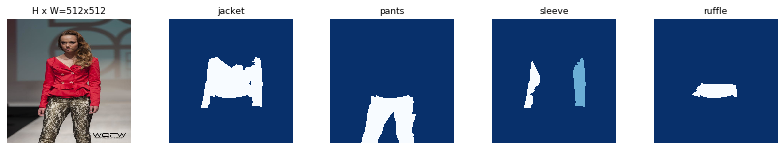

('/mnt/nas/iMaterial/train/f24374e1419a8bf66f360877602db59a.jpg', ['dress', 'neckline', 'shoe', 'shoe'])


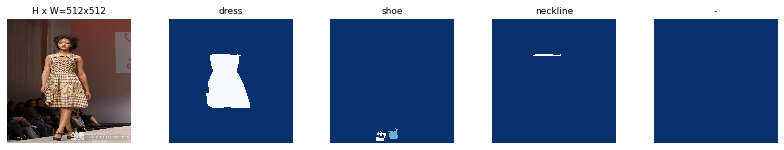

('/mnt/nas/iMaterial/train/3f2bbed88ba12cbac95512a9d7041798.jpg', ['zipper', 'dress', 'neckline', 'bag, wallet'])


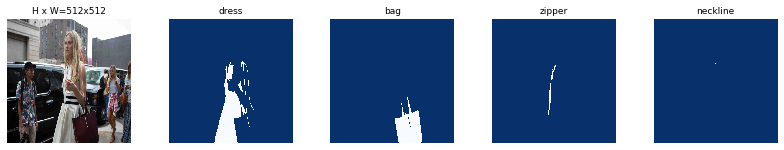

('/mnt/nas/iMaterial/train/8ee576d5a066aa1b375fe82fd507f623.jpg', ['shoe', 'shoe', 'jumpsuit', 'neckline'])


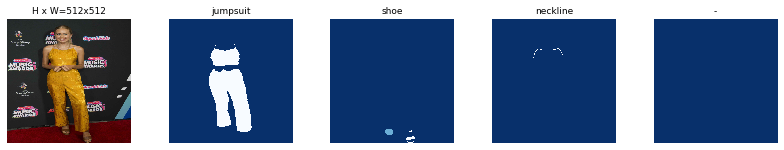

('/mnt/nas/iMaterial/train/7e76f7f974fabb6f8d2e89fd5ee56b74.jpg', ['dress', 'neckline', 'shoe', 'shoe', 'sleeve', 'sleeve'])


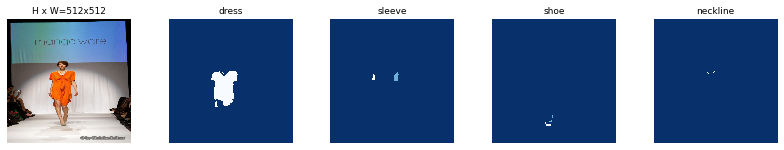

('/mnt/nas/iMaterial/train/b2faec9af5c0b3d4dc13086568cbb6b3.jpg', ['top, t-shirt, sweatshirt', 'neckline', 'sleeve', 'sleeve', 'pants', 'shoe', 'shoe', 'bag, wallet', 'glasses'])


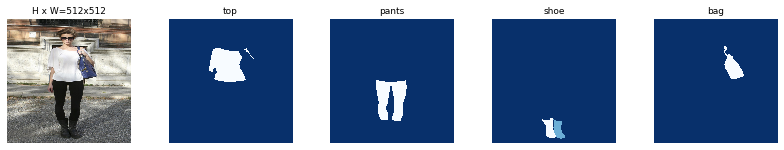

In [15]:
dataset = FashionDataset(image_df)
dataset.prepare()

for i in range(6):
    image_id = random.choice(dataset.image_ids)
    print(dataset.image_reference(image_id))
    
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names, limit=4)

In [16]:
# This code partially supports k-fold training, 
# you can specify the fold to train and the total number of folds here
FOLD = 0
N_FOLDS = 5

kf = KFold(n_splits=N_FOLDS, random_state=42, shuffle=True)
splits = kf.split(image_df) # ideally, this should be multilabel stratification

def get_fold():    
    for i, (train_index, valid_index) in enumerate(splits):
        if i == FOLD:
            return image_df.iloc[train_index], image_df.iloc[valid_index]
        
train_df, valid_df = get_fold()

train_dataset = FashionDataset(train_df)
train_dataset.prepare()

valid_dataset = FashionDataset(valid_df)
valid_dataset.prepare()

In [17]:
train_segments = np.concatenate(train_df['CategoryId'].values).astype(int)
print("Total train images: ", len(train_df))
print("Total train segments: ", len(train_segments))

plt.figure(figsize=(12, 3))
values, counts = np.unique(train_segments, return_counts=True)
print(label_names,counts)

Total train images:  36500
Total train segments:  267004
['shirt, blouse', 'top, t-shirt, sweatshirt', 'sweater', 'cardigan', 'jacket', 'vest', 'pants', 'shorts', 'skirt', 'coat', 'dress', 'jumpsuit', 'cape', 'glasses', 'hat', 'headband, head covering, hair accessory', 'tie', 'glove', 'watch', 'belt', 'leg warmer', 'tights, stockings', 'sock', 'shoe', 'bag, wallet', 'scarf', 'umbrella', 'hood', 'collar', 'lapel', 'epaulette', 'sleeve', 'pocket', 'neckline', 'buckle', 'zipper', 'applique', 'bead', 'bow', 'flower', 'fringe', 'ribbon', 'rivet', 'ruffle', 'sequin', 'tassel'] [ 4929 13219  1193   874  6269   585  9939  2186  4063  2503 14989   743
   116  3903  2036  2727  1157  1116  2700  5519    73  3494  2075 37078
  5794  1114   121   977  8117  4779   697 47660 21759 27377  2675  6390
  2865  4058   394  1101   479   226  3960  1950   740   285]


<Figure size 864x216 with 0 Axes>

In [18]:
targetClasses = [{'class':label_names[x], 'count':counts[x]} for x in values]
targetClasses

[{'class': 'shirt, blouse', 'count': 4929},
 {'class': 'top, t-shirt, sweatshirt', 'count': 13219},
 {'class': 'sweater', 'count': 1193},
 {'class': 'cardigan', 'count': 874},
 {'class': 'jacket', 'count': 6269},
 {'class': 'vest', 'count': 585},
 {'class': 'pants', 'count': 9939},
 {'class': 'shorts', 'count': 2186},
 {'class': 'skirt', 'count': 4063},
 {'class': 'coat', 'count': 2503},
 {'class': 'dress', 'count': 14989},
 {'class': 'jumpsuit', 'count': 743},
 {'class': 'cape', 'count': 116},
 {'class': 'glasses', 'count': 3903},
 {'class': 'hat', 'count': 2036},
 {'class': 'headband, head covering, hair accessory', 'count': 2727},
 {'class': 'tie', 'count': 1157},
 {'class': 'glove', 'count': 1116},
 {'class': 'watch', 'count': 2700},
 {'class': 'belt', 'count': 5519},
 {'class': 'leg warmer', 'count': 73},
 {'class': 'tights, stockings', 'count': 3494},
 {'class': 'sock', 'count': 2075},
 {'class': 'shoe', 'count': 37078},
 {'class': 'bag, wallet', 'count': 5794},
 {'class': 'scarf

Total train images:  36500
Total train segments:  267004


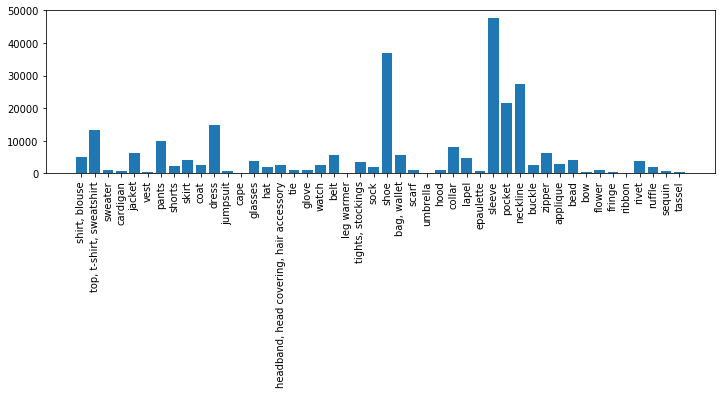

Total train images:  9125
Total validation segments:  66411


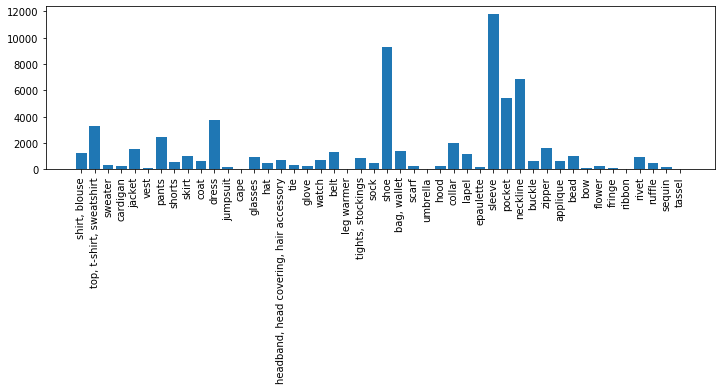

In [19]:
train_segments = np.concatenate(train_df['CategoryId'].values).astype(int)
print("Total train images: ", len(train_df))
print("Total train segments: ", len(train_segments))

plt.figure(figsize=(12, 3))
values, counts = np.unique(train_segments, return_counts=True)
plt.bar(values, counts)
plt.xticks(values, label_names, rotation='vertical')
plt.show()

valid_segments = np.concatenate(valid_df['CategoryId'].values).astype(int)
print("Total train images: ", len(valid_df))
print("Total validation segments: ", len(valid_segments))

plt.figure(figsize=(12, 3))
values, counts = np.unique(valid_segments, return_counts=True)
plt.bar(values, counts)
plt.xticks(values, label_names, rotation='vertical')
plt.show()

In [20]:
from sklearn.utils import class_weight
class_weight_array = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_segments),
                                                 train_segments)
config.class_weight = dict(enumerate(class_weight_array))

In [21]:
config.class_weight

{0: 1.1776090043839917,
 1: 0.439097872956252,
 2: 4.865410547031598,
 3: 6.641229728385236,
 4: 0.9258948448889289,
 5: 9.922110739502044,
 6: 0.5840059143383334,
 7: 2.655276661760611,
 8: 1.4286081177968732,
 9: 2.318991123695044,
 10: 0.38724629946018385,
 11: 7.812159868921529,
 12: 50.03823088455772,
 13: 1.4871726319776315,
 14: 2.8509011702400273,
 15: 2.128505604183607,
 16: 5.0167975649167635,
 17: 5.201106436029297,
 18: 2.1497906602254426,
 19: 1.0517185690539401,
 20: 79.512805241215,
 21: 1.6612578084169134,
 22: 2.797317967522263,
 23: 0.1565465985923916,
 24: 1.0018009635154808,
 25: 5.210444149558973,
 26: 47.970535393460295,
 27: 5.941079613724356,
 28: 0.7150960678340145,
 29: 1.2145709944776513,
 30: 8.327740003742749,
 31: 0.12178839241730373,
 32: 0.2667601811943883,
 33: 0.21201865736233683,
 34: 2.1698821617228767,
 35: 0.9083622507994829,
 36: 2.02598072691403,
 37: 1.4303683545117536,
 38: 14.732067976164203,
 39: 5.271966196738143,
 40: 12.117817917763457,
 4

In [28]:
# Note that any hyperparameters here, such as LR, may still not be optimal
LR = 1e-4
EPOCHS = [2, 6, 8, 10,100]

import warnings 
warnings.filterwarnings("ignore")


In [23]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)

model.load_weights(COCO_MODEL_PATH, by_name=True, exclude=[
    'mrcnn_class_logits', 'mrcnn_bbox_fc', 'mrcnn_bbox', 'mrcnn_mask'])

Instructions for updating:
Colocations handled automatically by placer.


In [27]:
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "fashion20191005T0834/mask_rcnn_fashion_0010.h5")
model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)

model.load_weights(COCO_MODEL_PATH, by_name=True, exclude=[
    'mrcnn_class_logits', 'mrcnn_bbox_fc', 'mrcnn_bbox', 'mrcnn_mask'])

Re-starting from epoch 10


In [24]:
sometimes = lambda aug: iaa.Sometimes(0.5, aug)
augmentation = iaa.SomeOf((0, 8),
    [iaa.Fliplr(0.5),
    sometimes(iaa.CropAndPad(
            percent=(-0.05, 0.1),
            pad_mode=ia.ALL,
            pad_cval=(0, 255)
        )),
    # convert images into their superpixel representation
    iaa.OneOf([
            iaa.GaussianBlur((0, 1.0)),
            # blur images with a sigma between 0 and 3.0
            iaa.AverageBlur(k=(3, 5)),
            # blur image using local means with kernel sizes between 2 and 7
            iaa.MedianBlur(k=(3, 5)),
            # blur image using local medians with kernel sizes between 2 and 7
    ]),
    iaa.Sharpen(alpha=(0, 1.0), lightness=(0.9, 1.1)),
    # sharpen images
    iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)),
    # emboss images
    # search either for all edges or for directed edges,
    # blend the result with the original image using a blobby mask
    iaa.SimplexNoiseAlpha(iaa.OneOf([
            iaa.EdgeDetect(alpha=(0.5, 1.0)),
            iaa.DirectedEdgeDetect(alpha=(0.5, 1.0),
                                    direction=(0.0, 1.0)),
    ])),
    iaa.AdditiveGaussianNoise(loc=0,
                                scale=(0.0, 0.01 * 255),
                                per_channel=0.5),
    # add gaussian noise to images
    iaa.OneOf([
            iaa.Dropout((0.01, 0.05), per_channel=0.5),
            # randomly remove up to 10% of the pixels
            iaa.CoarseDropout((0.01, 0.03),
                                size_percent=(0.01, 0.02),
                                per_channel=0.2),
    ]),
    iaa.OneOf([
            iaa.Clouds(),iaa.Fog()
    ]),
    iaa.Invert(0.01, per_channel=True),
    # invert color channels
    iaa.Add((-2, 2), per_channel=0.5),
    # change brightness of images (by -10 to 10 of original value)
    iaa.AddToHueAndSaturation((-1, 1)),
    # change hue and saturation
    # either change the brightness of the whole image (sometimes
    # per channel) or change the brightness of subareas
    iaa.OneOf([
            iaa.Multiply((0.9, 1.1), per_channel=0.5),
            iaa.FrequencyNoiseAlpha(
                    exponent=(-1, 0),
                    first=iaa.Multiply((0.9, 1.1),
                                        per_channel=True),
                    second=iaa.ContrastNormalization(
                            (0.9, 1.1))
            )
    ]),
    sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5),
                                        sigma=0.25)),
    # move pixels locally around (with random strengths)
    sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))),
    # sometimes move parts of the image around
    sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
    ],
    random_order=True
    )

In [29]:
%%time
model.train(train_dataset, valid_dataset,
            learning_rate=LR, # train heads with higher lr to speedup learning
            epochs=EPOCHS[4],
            layers='all',
            augmentation=augmentation)

history = model.keras_model.history.history


Starting at epoch 10. LR=0.0001

Checkpoint Path: /src/fashion20191005T0834/mask_rcnn_fashion_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b          (Batc

1000/1000 [==============================] - 795s 795ms/step - loss: 2.6980 - rpn_class_loss: 0.0704 - rpn_bbox_loss: 0.8059 - mrcnn_class_loss: 0.6593 - mrcnn_bbox_loss: 0.5414 - mrcnn_mask_loss: 0.6210 - val_loss: 2.1713 - val_rpn_class_loss: 0.0636 - val_rpn_bbox_loss: 0.7078 - val_mrcnn_class_loss: 0.4784 - val_mrcnn_bbox_loss: 0.4109 - val_mrcnn_mask_loss: 0.5106
Epoch 12/100
1000/1000 [==============================] - 562s 562ms/step - loss: 2.3741 - rpn_class_loss: 0.0921 - rpn_bbox_loss: 0.9481 - mrcnn_class_loss: 0.4261 - mrcnn_bbox_loss: 0.4155 - mrcnn_mask_loss: 0.4923 - val_loss: 1.9540 - val_rpn_class_loss: 0.0636 - val_rpn_bbox_loss: 0.6866 - val_mrcnn_class_loss: 0.4217 - val_mrcnn_bbox_loss: 0.3529 - val_mrcnn_mask_loss: 0.4293
Epoch 13/100
1000/1000 [==============================] - 564s 564ms/step - loss: 2.0899 - rpn_class_loss: 0.0704 - rpn_bbox_loss: 0.7803 - mrcnn_class_loss: 0.4201 - mrcnn_bbox_loss: 0.3713 - mrcnn_mask_loss: 0.4477 - val_loss: 1.9046 - val_rpn

1000/1000 [==============================] - 536s 536ms/step - loss: nan - rpn_class_loss: 0.7056 - rpn_bbox_loss: nan - mrcnn_class_loss: 4.4445 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 - val_loss: nan - val_rpn_class_loss: 0.7059 - val_rpn_bbox_loss: nan - val_mrcnn_class_loss: 4.4445 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 33/100
1000/1000 [==============================] - 541s 541ms/step - loss: nan - rpn_class_loss: 0.7057 - rpn_bbox_loss: nan - mrcnn_class_loss: 4.4445 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 - val_loss: nan - val_rpn_class_loss: 0.7058 - val_rpn_bbox_loss: nan - val_mrcnn_class_loss: 4.4445 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 34/100
1000/1000 [==============================] - 538s 538ms/step - loss: nan - rpn_class_loss: 0.7057 - rpn_bbox_loss: nan - mrcnn_class_loss: 4.4445 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 - val_loss: nan - 

1000/1000 [==============================] - 539s 539ms/step - loss: nan - rpn_class_loss: 0.7056 - rpn_bbox_loss: nan - mrcnn_class_loss: 4.4445 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 - val_loss: nan - val_rpn_class_loss: 0.7057 - val_rpn_bbox_loss: nan - val_mrcnn_class_loss: 4.4445 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 54/100
1000/1000 [==============================] - 537s 537ms/step - loss: nan - rpn_class_loss: 0.7057 - rpn_bbox_loss: nan - mrcnn_class_loss: 4.4445 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 - val_loss: nan - val_rpn_class_loss: 0.7059 - val_rpn_bbox_loss: nan - val_mrcnn_class_loss: 4.4445 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 55/100
1000/1000 [==============================] - 540s 540ms/step - loss: nan - rpn_class_loss: 0.7057 - rpn_bbox_loss: nan - mrcnn_class_loss: 4.4445 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 - val_loss: nan - 

1000/1000 [==============================] - 538s 538ms/step - loss: nan - rpn_class_loss: 0.7057 - rpn_bbox_loss: nan - mrcnn_class_loss: 4.4445 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 - val_loss: nan - val_rpn_class_loss: 0.7058 - val_rpn_bbox_loss: nan - val_mrcnn_class_loss: 4.4445 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 75/100
1000/1000 [==============================] - 540s 540ms/step - loss: nan - rpn_class_loss: 0.7057 - rpn_bbox_loss: nan - mrcnn_class_loss: 4.4445 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 - val_loss: nan - val_rpn_class_loss: 0.7058 - val_rpn_bbox_loss: nan - val_mrcnn_class_loss: 4.4445 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 76/100
1000/1000 [==============================] - 537s 537ms/step - loss: nan - rpn_class_loss: 0.7056 - rpn_bbox_loss: nan - mrcnn_class_loss: 4.4445 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 - val_loss: nan - 

1000/1000 [==============================] - 537s 537ms/step - loss: nan - rpn_class_loss: 0.7057 - rpn_bbox_loss: nan - mrcnn_class_loss: 4.4445 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 - val_loss: nan - val_rpn_class_loss: 0.7059 - val_rpn_bbox_loss: nan - val_mrcnn_class_loss: 4.4445 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 96/100
1000/1000 [==============================] - 539s 539ms/step - loss: nan - rpn_class_loss: 0.7057 - rpn_bbox_loss: nan - mrcnn_class_loss: 4.4445 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 - val_loss: nan - val_rpn_class_loss: 0.7057 - val_rpn_bbox_loss: nan - val_mrcnn_class_loss: 4.4445 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 97/100
1000/1000 [==============================] - 540s 540ms/step - loss: nan - rpn_class_loss: 0.7057 - rpn_bbox_loss: nan - mrcnn_class_loss: 4.4445 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 - val_loss: nan - 

In [ ]:
# glob_list = glob.glob(f'/kaggle/working/fashion*/mask_rcnn_fashion_{best_epoch:04d}.h5')
# model_path = glob_list[0] if glob_list else ''

In [26]:
trained_model_path = os.path.join(ROOT_DIR, "bestModel/balance_all_Aug_10.h5")

In [ ]:
class InferenceConfig(FashionConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

assert trained_model_path != '', "Provide path to trained weights"
print("Loading weights from ", trained_model_path)
model.load_weights(trained_model_path, by_name=True)

In [ ]:
sample_df = pd.read_csv(DATA_DIR/"sample_submission.csv")
sample_df.head()

In [ ]:
# Convert data to run-length encoding
def to_rle(bits):
    rle = []
    pos = 0
    for bit, group in itertools.groupby(bits):
        group_list = list(group)
        if bit:
            rle.extend([pos, sum(group_list)])
        pos += len(group_list)
    return rle

In [ ]:
# Since the submission system does not permit overlapped masks, we have to fix them
def refine_masks(masks, rois):
    areas = np.sum(masks.reshape(-1, masks.shape[-1]), axis=0)
    mask_index = np.argsort(areas)
    union_mask = np.zeros(masks.shape[:-1], dtype=bool)
    for m in mask_index:
        masks[:, :, m] = np.logical_and(masks[:, :, m], np.logical_not(union_mask))
        union_mask = np.logical_or(masks[:, :, m], union_mask)
    for m in range(masks.shape[-1]):
        mask_pos = np.where(masks[:, :, m]==True)
        if np.any(mask_pos):
            y1, x1 = np.min(mask_pos, axis=1)
            y2, x2 = np.max(mask_pos, axis=1)
            rois[m, :] = [y1, x1, y2, x2]
    return masks, rois

In [ ]:
for i in range(9):
    image_id = sample_df.sample()['ImageId'].values[0]
    image_path = str(IMAGE_DIR/'test'/image_id)
    
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    result = model.detect([resize_image(image_path)])
    r = result[0]
    
    if r['masks'].size > 0:
        masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
        for m in range(r['masks'].shape[-1]):
            masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'), 
                                        (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
        
        y_scale = img.shape[0]/IMAGE_SIZE
        x_scale = img.shape[1]/IMAGE_SIZE
        rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)
        
        masks, rois = refine_masks(masks, rois)
    else:
        masks, rois = r['masks'], r['rois']
        
    visualize.display_instances(img, rois, masks, r['class_ids'], 
                                ['bg']+label_names, r['scores'],
                                title=image_id, figsize=(12, 12))

In [ ]:
# train all
for i in range(9):
    image_id = sample_df.sample()['ImageId'].values[0]
    image_path = str(IMAGE_DIR/'test'/image_id)
    
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    result = model.detect([resize_image(image_path)])
    r = result[0]
    
    if r['masks'].size > 0:
        masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
        for m in range(r['masks'].shape[-1]):
            masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'), 
                                        (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
        
        y_scale = img.shape[0]/IMAGE_SIZE
        x_scale = img.shape[1]/IMAGE_SIZE
        rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)
        
        masks, rois = refine_masks(masks, rois)
    else:
        masks, rois = r['masks'], r['rois']
        
    visualize.display_instances(img, rois, masks, r['class_ids'], 
                                ['bg']+label_names, r['scores'],
                                title=image_id, figsize=(12, 12))